# NEURAL MACHINE TRANSLATION

In this notebook we will implement a Machine Translator using a **Sequence to Sequence (Encoder-Decoder) LSTM Network with Attention**.

Specifically we will tackle:
    1. English to German text translation
    
    2. French to English text translation
    
### Dataset

We are using the Open Subtitles Dataset (http://opus.lingfil.uu.se/OpenSubtitles.php) which is a collection of documents from http://www.opensubtitles.org/. So basically the data comprises of movie subtitles in different languages.
We have chosen data for English-> German task and French-> English translation task. 

Note - Some language data is in a TMX format, which needs to be converted in a useful format before we train our model. I have written a TMX convertor which accomplishes this task, and can be used on any language dataset for creating a machine translator.

Data preprocessing includes:
    1. Tokenizing 
    2. Anonymizing rare words <ukn> 
    3. Adding start (<go>) and end (<eos>) tokens to the sequences
    4. Padding sequences <pad>
    5. One hot encoding sequences
    
These tasks are handled in the helper script data_utils.py

In [2]:
# dependencies
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import data_utils
import matplotlib.pyplot as plt

### Helper Functions

In [ ]:
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

## ENGLISH TO GERMAN TRANSLATOR

In [2]:
# read dataset
X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = data_utils.read_dataset('data.pkl')

In [3]:
# inspect data
print 'Sentence in English - encoded:', X[0]
print 'Sentence in German - encoded:', Y[0]
print 'Decoded:\n------------------------'

for i in range(len(X[0])):
    print en_idx2word[X[0][i]],
    
print '\n'

for i in range(len(Y[0])):
    print de_idx2word[Y[0][i]],

Sentence in English - encoded: [108, 5, 867, 93, 38, 25, 2583]
Sentence in German - encoded: [166, 262, 8, 474, 268, 324, 67, 15, 130]
Decoded:
------------------------
Well I suppose it' il be alright 

Na schön ich denke dieses Mal wird es gehen


In [4]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [5]:
# build a model

input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [6]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [8]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 1000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [11]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print '------------------TRAINING------------------'

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print 'step: {}, loss: {}'.format(step, loss_value)
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print 'Checkpoint is saved'
            
    print 'Training time for {} steps: {}s'.format(steps, time.time() - t)

------------------TRAINING------------------
step: 0, loss: 9.15700340271
step: 4, loss: 9.16397285461
step: 9, loss: 9.00219345093
step: 14, loss: 9.09013843536
step: 19, loss: 9.02696609497
Checkpoint is saved
step: 24, loss: 8.9703540802
step: 29, loss: 8.98925685883
step: 34, loss: 8.76154136658
step: 39, loss: 8.15525436401
Checkpoint is saved
step: 44, loss: 7.24500846863
step: 49, loss: 7.15777587891
step: 54, loss: 7.11880111694
step: 59, loss: 6.68689155579
Checkpoint is saved
step: 64, loss: 6.33931493759
step: 69, loss: 6.3931517601
step: 74, loss: 5.88977241516
step: 79, loss: 5.81943750381
Checkpoint is saved
step: 84, loss: 5.61211776733
step: 89, loss: 5.38785266876
step: 94, loss: 5.37372303009
step: 99, loss: 5.86443328857
Checkpoint is saved
step: 104, loss: 5.84311008453
step: 109, loss: 5.39813232422
step: 114, loss: 5.33500385284
step: 119, loss: 5.07542133331
Checkpoint is saved
step: 124, loss: 5.9093875885
step: 129, loss: 5.23268318176
step: 134, loss: 5.035477

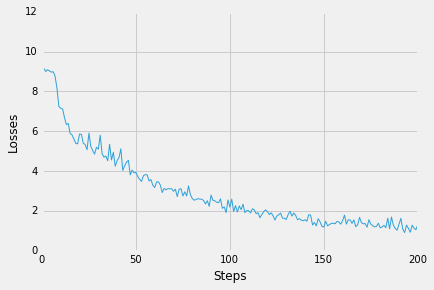

In [12]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

## Testing Our Trained NMT (English => German)

In [13]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ["What' s your name", 'My name is', 'What are you doing', 'I am reading a book',\
                    'How are you', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print '{}.\n--------------------------------'.format(i+1)
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print en_sentences[i]
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print words[i],
            
            print '\n--------------------------------'

1.
--------------------------------
What' s your name
Was ist denn Name 
--------------------------------
2.
--------------------------------
My name is
Mein Name ist 
--------------------------------
3.
--------------------------------
What are you doing
Was machst du gemacht 
--------------------------------
4.
--------------------------------
I am reading a book
Ich bin ein Buch Buch 
--------------------------------
5.
--------------------------------
How are you
Wie geht' s 
--------------------------------
6.
--------------------------------
I am good
Ich bin gut 
--------------------------------
7.
--------------------------------
Do you speak English
Mach du Ihnen an 
--------------------------------
8.
--------------------------------
What time is it
Was ist es 
--------------------------------
9.
--------------------------------
Hi
Hallo 
--------------------------------
10.
--------------------------------
Goodbye
Wiedersehen 
--------------------------------
11.
-----------

## FRENCH TO ENGLISH TRANSLATOR

In [3]:
X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = data_utils.read_dataset('data_fr_en.pkl')

In [5]:
print 'Sentence in English - encoded:', X[1]
print 'Sentence in German - encoded:', Y[1]
print 'Decoded:\n------------------------'

for i in range(len(X[1])):
    print en_idx2word[X[1][i]],
    
print '\n'

for i in range(len(Y[1])):
    print de_idx2word[Y[1][i]],

Sentence in English - encoded: [3, 1492, 941, 28]
Sentence in German - encoded: [7, 357, 18, 201]
Decoded:
------------------------
- D&apos;abord dis- moi 

- Tell me first


In [6]:
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [7]:
input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [8]:
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [10]:
learning_rate = 5e-3
batch_size = 64
steps = 1000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [11]:
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print '------------------TRAINING------------------'

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print 'step: {}, loss: {}'.format(step, loss_value)
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print 'Checkpoint is saved'
            
    print 'Training time for {} steps: {}s'.format(steps, time.time() - t)

------------------TRAINING------------------
step: 0, loss: 9.28539276123
step: 4, loss: 9.27874851227
step: 9, loss: 9.21777153015
step: 14, loss: 9.17447471619
step: 19, loss: 9.08433818817
Checkpoint is saved
step: 24, loss: 9.17327880859
step: 29, loss: 8.97542762756
step: 34, loss: 8.93514156342
step: 39, loss: 8.60582542419
Checkpoint is saved
step: 44, loss: 7.64345264435
step: 49, loss: 7.46297550201
step: 54, loss: 7.42553424835
step: 59, loss: 6.85999155045
Checkpoint is saved
step: 64, loss: 6.22163677216
step: 69, loss: 6.94149065018
step: 74, loss: 5.9013004303
step: 79, loss: 6.42337560654
Checkpoint is saved
step: 84, loss: 6.68325567245
step: 89, loss: 5.53163719177
step: 94, loss: 5.89535140991
step: 99, loss: 5.56395626068
Checkpoint is saved
step: 104, loss: 6.669090271
step: 109, loss: 5.18537902832
step: 114, loss: 5.21751308441
step: 119, loss: 6.06572628021
Checkpoint is saved
step: 124, loss: 5.74199199677
step: 129, loss: 4.8985004425
step: 134, loss: 5.1176552

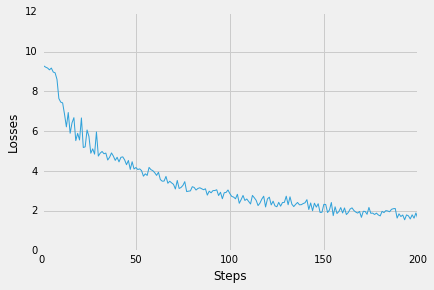

In [12]:
with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

## Testing Our Trained NMT (French => English)

In [16]:
with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    fr_sentences = ["Quel est ton nom", "Mon nom est", "Qu'est-ce que tu fais", "je lis un livre","Comment allez-vous", "je vais bien", "Parlez vous anglais", "Quelle heure est-il", "salut", "Au Revoir", "Oui", "Non"]
    fr_sentences_encoded = [[en_word2idx.get(word, 0) for word in fr_sentence.split()] for fr_sentence in fr_sentences]
    
    # padding to fit encoder input
    for i in range(len(fr_sentences_encoded)):
        fr_sentences_encoded[i] += (15 - len(fr_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([fr_sentences_encoded[j][i] for j in range(len(fr_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(fr_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(fr_sentences_encoded)):
            print '{}.\n--------------------------------'.format(i+1)
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print fr_sentences[i]
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print words[i],
            
            print '\n--------------------------------'

1.
--------------------------------
Quel est ton nom
What is your name 
--------------------------------
2.
--------------------------------
Mon nom est
My name is 
--------------------------------
3.
--------------------------------
Qu'est-ce que tu fais
- You are wrong 
--------------------------------
4.
--------------------------------
je lis un livre
I wanna wanna like a book 
--------------------------------
5.
--------------------------------
Comment allez-vous
How <ukn> 
--------------------------------
6.
--------------------------------
je vais bien
I&apos m going 
--------------------------------
7.
--------------------------------
Parlez vous anglais
- You thought you 
--------------------------------
8.
--------------------------------
Quelle heure est-il
What <ukn> <ukn> 
--------------------------------
9.
--------------------------------
salut
<ukn> 
--------------------------------
10.
--------------------------------
Au Revoir
A <ukn> 
--------------------------------

As can be deduced, the results are pretty decent. Now we have Neural Machine Translator (NMT) that can convert English to German and French to English. 

Training reverse models is just task of interchanging inputs and outputs!

Perhaps I must deploy these trained models in an Android app, and I believe I shall be ready for an Euro Trip!!! 